In [1]:
%load_ext autoreload
%autoreload 2

# EEG models analysis

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import os

## Display learning curves

In [3]:
def results_path(model_date):
    return os.path.join("./Results/Pre_Training/EEG", model_date)

def print_learning_curves(models, model_name):
    model_date = models[model_name]
    file_test_results = os.path.join(results_path(model_date), 'EEG_linear_result.txt')
    results = pd.read_csv(file_test_results, sep=', ').set_index('#')
    # Create figure with 2 subplots
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for col in ['train_loss', 'test_loss']:
        plt.plot(results[col], label=col)
    plt.ylabel('Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.title(f'Learning curves for model {model_name}')
    plt.subplot(1, 2, 2)
    acc_columns = [col for col in results.columns if 'acc' in col]
    for col in acc_columns:
        plt.plot(results[col], label=col)
    plt.legend()
    plt.xlabel('Epoch')
    plt.title(f'Learning curves for model {model_name}')
    plt.show()
    return results

/var/tmp/ipykernel_26520/1241755508.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  results = pd.read_csv(file_test_results, sep=', ').set_index('#')


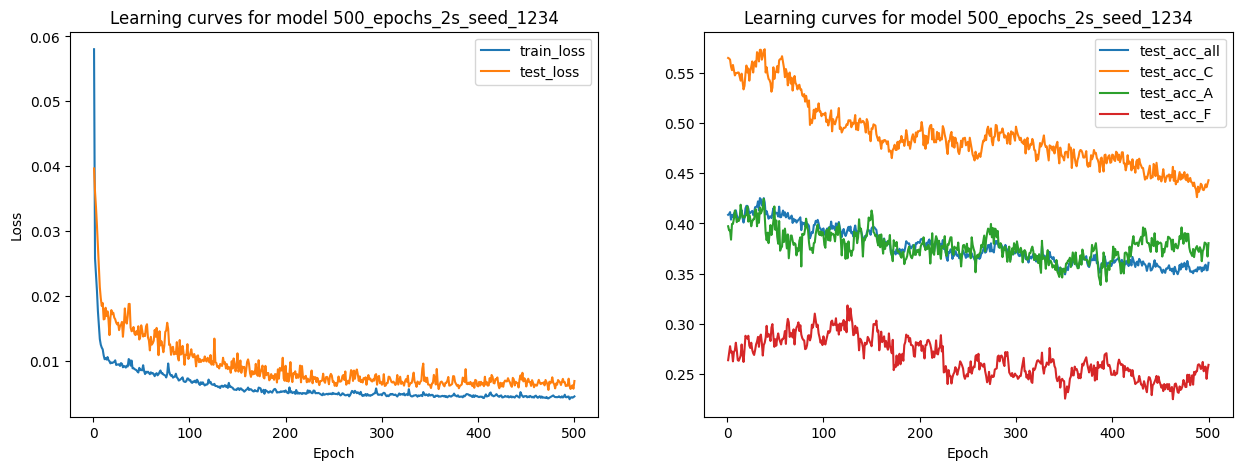

In [4]:
# Write reference of models to analyse with a name to identify them
models = {"500_epochs_2s_seed_1234":"2024-10-11_14-02",
          "500_epochs_2s_seed_17":"2024-10-11_19-29"}

results = print_learning_curves(models, "500_epochs_2s_seed_1234")

## Try fitting ML model to embeddings

Current root path (path to EEG dataset): ./Dataset/EEG/EEG/
Using data from preloaded Raw for 299 events and 200 original time points ...
Using data from preloaded Raw for 396 events and 200 original time points ...
Using data from preloaded Raw for 152 events and 200 original time points ...
Using data from preloaded Raw for 351 events and 200 original time points ...
Using data from preloaded Raw for 402 events and 200 original time points ...
Using data from preloaded Raw for 312 events and 200 original time points ...
Using data from preloaded Raw for 380 events and 200 original time points ...
Using data from preloaded Raw for 389 events and 200 original time points ...
Using data from preloaded Raw for 304 events and 200 original time points ...
Using data from preloaded Raw for 629 events and 200 original time points ...
Using data from preloaded Raw for 382 events and 200 original time points ...
Using data from preloaded Raw for 425 events and 200 original time points ...
Usin

2024-10-12 10:46:05,870 | INFO : 19137 samples will be used for training
2024-10-12 10:46:05,872 | INFO : Train Data Shape is #19137 samples, 2 channels, 200 time steps 
2024-10-12 10:46:05,872 | INFO : 5181 samples will be used for testing
2024-10-12 10:46:05,941 | INFO : Model:
Seires2Vec(
  (embed_layer): DisjoinEncoder(
    (temporal_CNN): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 8), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (spatial_CNN): Sequential(
      (0): Conv2d(16, 16, kernel_size=(2, 1), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (rep_CNN): Sequential(
      (0): Conv1d(16, 128, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
  )
  (embed_layer_f): Disjoi

Loaded model from ./Results/Pre_Training/EEG/2024-10-11_14-02/checkpoints/EEG_model_last.pth. Epoch: 495


/home/pauli/self-supervised-learning-eeg/models/Series2Vec/Series2Vec.py:44: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  x_f = torch.fft.fft(x).float()


NameError: name 'root_path' is not defined

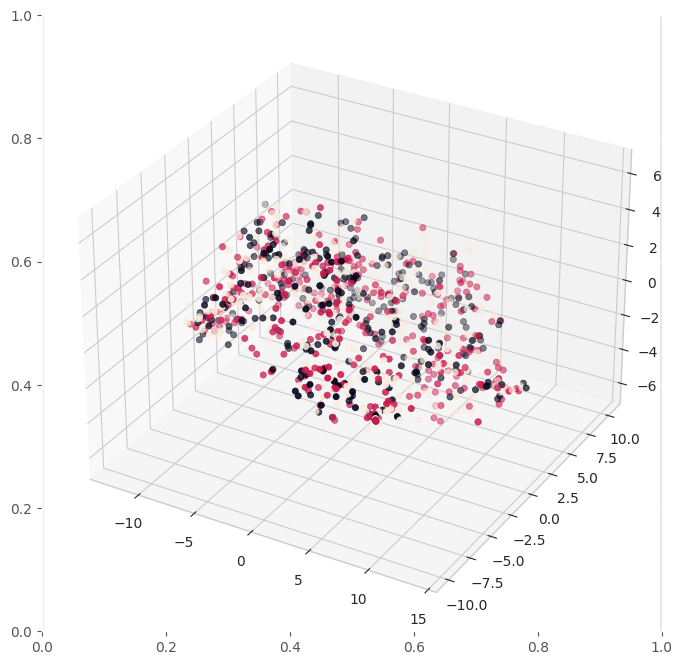

In [58]:
from visualize import load_config_from_json, visualize
from models.model_factory import Model_factory
from Dataset.dataloader import data_loader, dataset_class
from torch.utils.data import DataLoader
from torch import tensor
from Dataset.dataloader import dataset_class
from utils.utils import load_model
from models.Series2Vec.S2V_training import S2V_make_representation

problem = "EEG"
root_path = "./"
result_path = "Results/Pre_Training/EEG/2024-10-11_14-02"
config = load_config_from_json(root_path, result_path, problem)
Data = data_loader(config, is_analysis=True)
model = Model_factory(config, Data)

# --------------------------------- Load Data ---------------------------------
train_dataset = dataset_class(Data['train_data'], Data['train_label'], config)
test_dataset = dataset_class(Data['test_data'], Data['test_label'], config)

train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

# --------------------------------- Load Model --------------------------------
SS_Encoder = load_model(model, model_path=config['model_dir'], optimizer=None)  # Loading the model
SS_Encoder.to(config['device'])
train_repr, train_labels = S2V_make_representation(SS_Encoder, train_loader)
test_repr, test_labels = S2V_make_representation(SS_Encoder, test_loader)

# ------------------------------- Visualize Test ------------------------------
visualize(X=train_repr, 
          y=train_labels,
          reducer_type='tsne', # 'tsne', 'umap''
          problem=problem, 
          n_components=3, # 2, 3
          n_points=1000
          )


In [36]:
test_repr, test_labels = S2V_make_representation(SS_Encoder, test_loader)

In [61]:
from Dataset.dataloader import data_loader
from torch import tensor

In [45]:
import numpy as np
subjects = Data['train_subjects']
ids_group = [[sub.participant_id]*len(sub.epochs) for sub in subjects]

import itertools
ids_group = np.array(list(itertools.chain.from_iterable(ids_group)))
ids_group.shape


(26865,)

In [46]:
Data = data_loader(config, is_analysis=True)

Current root path (path to EEG dataset): ./Dataset/EEG/EEG/
Using data from preloaded Raw for 299 events and 200 original time points ...
Using data from preloaded Raw for 396 events and 200 original time points ...
Using data from preloaded Raw for 152 events and 200 original time points ...
Using data from preloaded Raw for 351 events and 200 original time points ...
Using data from preloaded Raw for 402 events and 200 original time points ...
Using data from preloaded Raw for 312 events and 200 original time points ...
Using data from preloaded Raw for 380 events and 200 original time points ...
Using data from preloaded Raw for 389 events and 200 original time points ...
Using data from preloaded Raw for 304 events and 200 original time points ...
Using data from preloaded Raw for 629 events and 200 original time points ...
Using data from preloaded Raw for 382 events and 200 original time points ...
Using data from preloaded Raw for 425 events and 200 original time points ...
Usin

2024-10-12 10:37:31,480 | INFO : 19137 samples will be used for training
2024-10-12 10:37:31,481 | INFO : Train Data Shape is #19137 samples, 2 channels, 200 time steps 
2024-10-12 10:37:31,482 | INFO : 5181 samples will be used for testing


In [74]:
from Dataset.EEG.EEG.EEG_Loader import load_participants

subjects = load_participants("Dataset/EEG/EEG/participants.tsv")
subjects = subjects.set_index('participant_id')
subjects.to_dict()

train_gender = tensor(np.array([gender_encoding(subjects['Gender'][ID]) for ID in Data['train_ids']]))
test_gender = tensor(np.array([gender_encoding(subjects['Gender'][ID]) for ID in Data['test_ids']]))

train_age = tensor(np.array([subjects['Age'][ID] for ID in Data['train_ids']]))
test_age = tensor(np.array([subjects['Age'][ID] for ID in Data['test_ids']]))

In [65]:
def gender_encoding(gender_str):
    if gender_str == 'F':
        return 0
    else:
        return 1

NameError: name 'root_path' is not defined

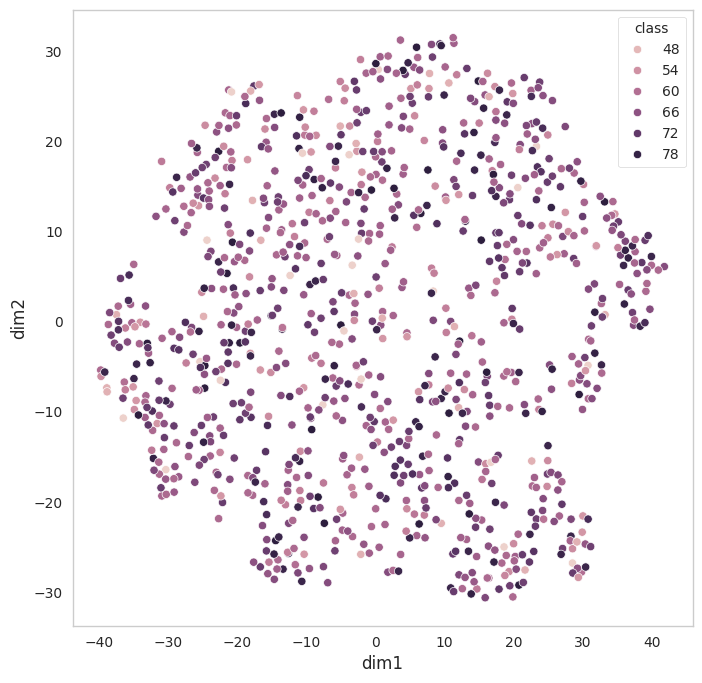

In [76]:
# ------------------------------- Visualize Test ------------------------------
visualize(X=train_repr, 
          y=train_age,
          reducer_type='umap', # 'tsne', 'umap''
          problem=problem, 
          n_components=2, # 2, 3
          n_points=1000
          )

In [42]:
# Create SVM classifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create pipeline
clf = SVC(C=1, gamma=2)
clf.fit(train_repr.cpu(), train_labels.cpu())
y_pred = clf.predict(test_repr.cpu())

print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.30      0.31      1727
           1       0.35      0.40      0.37      1727
           2       0.31      0.28      0.29      1727

    accuracy                           0.33      5181
   macro avg       0.33      0.33      0.33      5181
weighted avg       0.33      0.33      0.33      5181

